# Web Traffic Analysis
This covers the web traffic analysis of the iNethi network at three vantage points (mesh, school, servers)

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import calendar
from scipy.stats import describe
from scipy import stats
from user_agents import parse

import seaborn as sns
#sns.set(style="ticks", palette="pastel")

plt.style.use('default')

def extractLocalTraffic(df, fieldname):
    df_local = df.loc[df.ip_dst.str.startswith('10.', na=False)]
    df_local = df_local.loc[df_local.ip_src.str.startswith('10.', na=False)]
    df_local = df_local.groupby(['date']).count()[['ip_src']]
    df_local.index = pd.to_datetime(df_local.index, dayfirst=False)
    df_local.columns=[fieldname]
    df_local = df_local.resample('D').sum()
    df_local = df_local.reset_index()
    return df_local

def extractGlobalTraffic(df, fieldname):
    df_global = df.loc[~(df.ip_dst.str.startswith('10.', na=False))]
    df_global = df_global.loc[df_global.ip_src.str.startswith('10.', na=False)]
    df_global = df_global.groupby(['date']).count()[['ip_src']]
    df_global.index = pd.to_datetime(df_global.index, dayfirst=False)
    df_global.columns=[fieldname]
    df_global = df_global.resample('D').sum()
    df_global = df_global.reset_index()
    return df_global


In [2]:
df_mesh = pd.read_csv('data/stats/http/mesh.csv', sep='|', error_bad_lines=False)
df_school = pd.read_csv('data/stats/http/school.csv', sep='|', error_bad_lines=False)
df_servers = pd.read_csv('data/stats/http/servers.csv', sep='|', error_bad_lines=False)

/Users/amreesh/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/amreesh/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/amreesh/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## User-agents
Study the different types of user-agents and extract the phone and browser used

In [3]:
df_uas = pd.DataFrame(columns=['ua', 'brand', 'os', 'browser', 'mobile', 'tablet', 'pc', 'bot','touch'])

ua_mesh_array = np.array(df_mesh.user_agent.unique())
ua_school_array = np.array(df_school.user_agent.unique())
ua_servers_array = np.array(df_servers.user_agent.unique())

ua_array = np.concatenate((ua_mesh_array, ua_school_array, ua_servers_array), axis=0)

ua_array = ua_array[~pd.isnull(ua_array)]

for ua_string in ua_array:
    user_agent = parse(ua_string)
    summary = str(user_agent)
    df_uas = df_uas.append({'ua' : ua_string, 
                           'brand': summary.split('/')[0] , 
                           'os': summary.split('/')[1] , 
                           'browser': summary.split('/')[2], 
                           'mobile': user_agent.is_mobile, 
                           'tablet': user_agent.is_tablet , 
                           'pc': user_agent.is_pc, 
                           'bot': user_agent.is_bot,
                           'touch': user_agent.is_touch_capable}, ignore_index=True)
df_uas.head()

,ua,brand,os,browser,mobile,tablet,pc,bot,touch
0,Avast NCC,Other,Other,Other,False,False,False,False,False
1,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,PC,Linux,Chrome 60.0.3112,False,False,True,False,False
2,Dalvik/1.6.0 (Linux; U; Android 4.3; GT-I9500 ...,Samsung GT-I9500,Android 4.3,Android 4.3,False,True,False,False,True
3,Dalvik/2.1.0 (Linux; U; Android 8.1.0; ASTRO B...,ASTRO,Android 8.1.0,Android 8.1.0,False,True,False,False,True
4,Dalvik/2.1.0 (Linux; U; Android 7.0; S61 JAZZ ...,S61 JAZZ,Android 7.0,Android 7.0,False,True,False,False,True


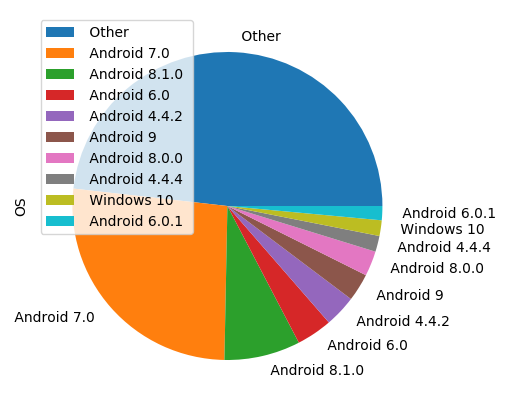

In [233]:
#fig, ax = plt.subplots(figsize=(5, 5))

ax = df_uas.groupby(['os']).count()[['ua']].sort_values('ua', ascending=False)[:10].plot(x='os', y='ua', kind='pie', label='OS', figsize=(5, 5))

# plt.legend(loc='best')
# plt.savefig('plots/pie_os_distribution.pdf')
# plt.show()


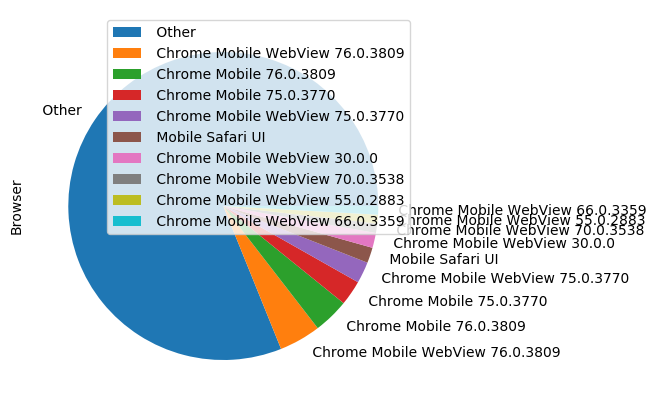

In [124]:
df_browser = df_uas.loc[~df_uas.browser.str.startswith(' Android')]

df_browser.groupby(['browser']).count()[['ua']].sort_values('ua', ascending=False)[:10].plot(x='browser', y='ua', kind='pie', figsize=(5, 5), label='Browser')

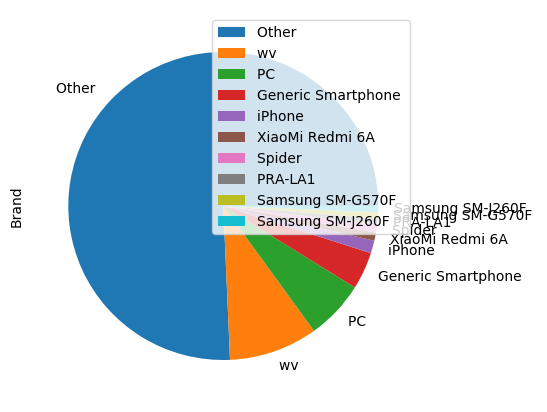

In [234]:
df_browser.groupby(['brand']).count()[['ua']].sort_values('ua', ascending=False)[:10].plot(x='brand', y='ua', kind='pie', figsize=(5, 5), label='Brand')

### Hits on local vs global services

In [78]:
df_local_mesh = extractLocalTraffic(df_mesh, 'mesh')
df_local_school = extractLocalTraffic(df_school, 'school')
df_local_servers = extractLocalTraffic(df_servers, 'servers')

In [95]:
df_global_mesh = extractGlobalTraffic(df_mesh, 'mesh')
df_global_school = extractGlobalTraffic(df_school, 'school')
df_global_servers = extractGlobalTraffic(df_servers, 'servers')

In [97]:
df_local_mesh.head()

,date,mesh
0,2019-07-29,7760
1,2019-07-30,28130
2,2019-07-31,28813
3,2019-08-01,19054
4,2019-08-02,28468


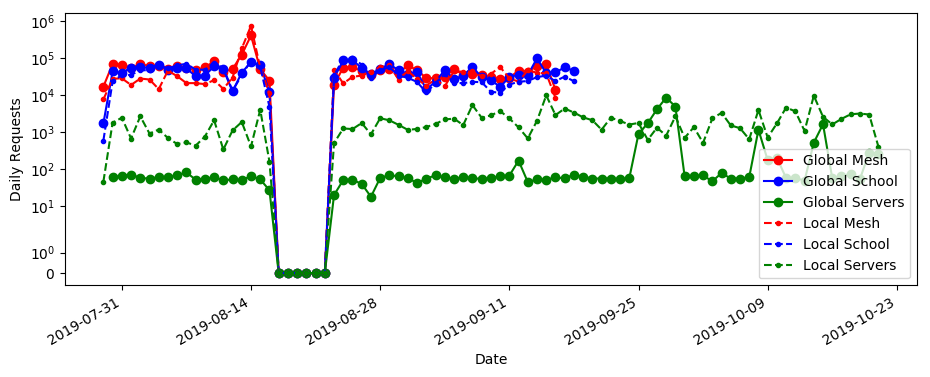

In [161]:
fig, ax = plt.subplots(figsize=(11, 4))

# df_local_mesh.plot(ax, x="date", y=["mesh"], kind="line", marker='.', linestyle='-', )
# df_local_school.plot(ax, x="date", y=["school"], kind="line", marker='.', linestyle='-')
# df_local_servers.plot(ax, x="date", y=["servers"], kind="line", marker='.', linestyle='-')

ax.plot(df_global_mesh.date, df_global_mesh.mesh, marker='o', linestyle='-', color='red', label='Global Mesh')
ax.plot(df_global_school.date, df_global_school.school, marker='o', linestyle='-', color='blue', label='Global School')
ax.plot(df_global_servers.date, df_global_servers.servers, marker='o', linestyle='-', color='green', label='Global Servers')

ax.plot(df_local_mesh.date, df_local_mesh.mesh, marker='.', linestyle='--', color='red', label='Local Mesh')
ax.plot(df_local_school.date, df_local_school.school, marker='.', linestyle='--', color='blue', label='Local School')
ax.plot(df_local_servers.date, df_local_servers.servers, marker='.', linestyle='--', color='green', label='Local Servers')

ax.set_ylabel('Daily Requests')
ax.set_xlabel('Date')
ax.set_yscale('symlog')
fig.autofmt_xdate()

ax.legend()

plt.savefig('plots/http_daily_requests.pdf')
plt.show()

### Most visited websites
N.B Website hits not the most used on in terms of traffic 

#### Mesh

In [ ]:
df_external = df_mesh[df_mesh['host'].notnull()]
df_external = df_external.loc[~df_external.ip_dst.str.startswith('10.', na=False)]
df_external['short_host'] = df_external.apply(lambda x: '.'.join(x.host.split('.')[-2:]), axis=1)
df_external = df_external.groupby(['short_host']).count()[['ip_src']]
df_external.sort_values(['ip_src'], ascending=False, inplace=True)
#df_external = df_external.drop_duplicates()
df_external = df_external.reset_index()
df_external.head(40)

In [224]:
df_external = df_external.drop([40])

In [240]:
df_external[df_external.short_host=='youtube.com']

,short_host,ip_src
168,youtube.com,251


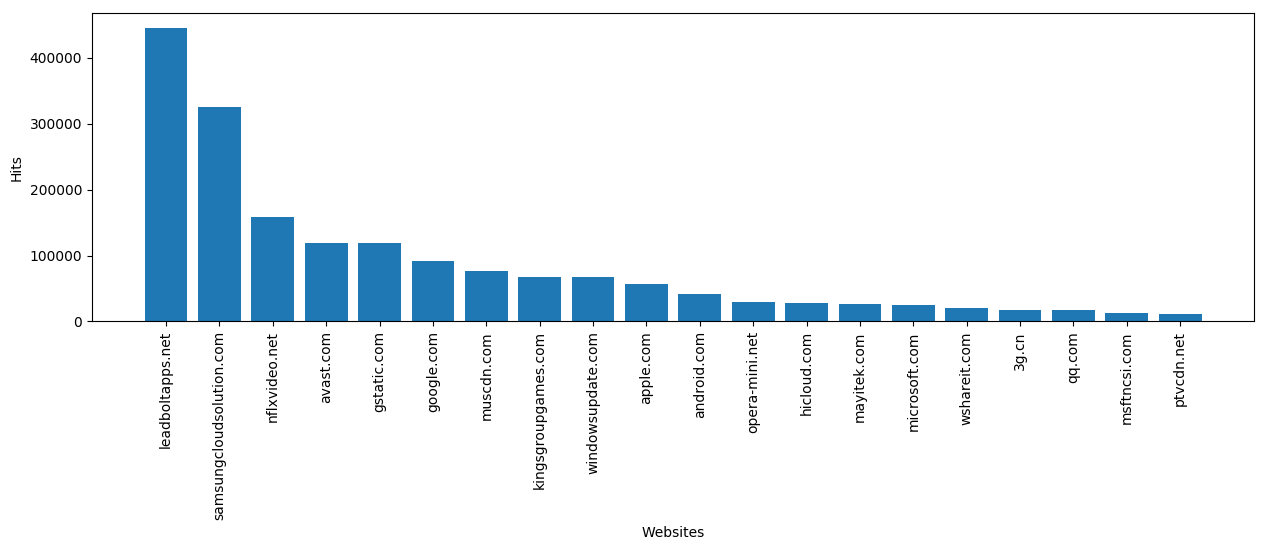

In [227]:
fig, ax = plt.subplots(figsize=(15, 4))

df_list = df_external[:20]

ax.bar(df_list.short_host, df_list.ip_src)

plt.xticks(fontsize=10, rotation='vertical')

ax.set_ylabel('Hits')
ax.set_xlabel('Websites')

plt.savefig('plots/http_hitlists_mesh.pdf')
plt.show()


#### School

In [ ]:
df_school_ext = df_school[df_school['host'].notnull()]
df_school_ext = df_school_ext.loc[~df_school_ext.ip_dst.str.startswith('10.', na=False)]
df_school_ext['short_host'] = df_school_ext.apply(lambda x: '.'.join(x.host.split('.')[-2:]), axis=1)
df_school_ext = df_school_ext.groupby(['short_host']).count()[['ip_src']]
df_school_ext.sort_values(['ip_src'], ascending=False, inplace=True)
#df_school_ext = df_school_ext.drop_duplicates()
df_school_ext = df_school_ext.reset_index()
df_school_ext.head(40)

In [217]:
df_school_ext = df_school_ext.drop([1,23,35])

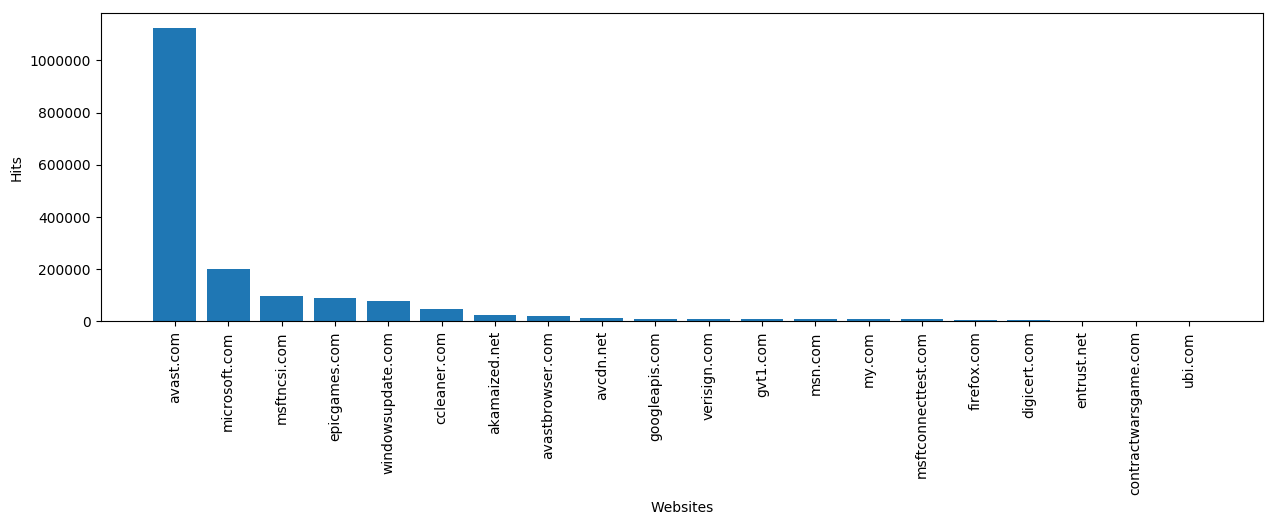

In [228]:
fig, ax = plt.subplots(figsize=(15, 4))

df_list = df_school_ext[:20]

ax.bar(df_list.short_host, df_list.ip_src)

plt.xticks(fontsize=10, rotation='vertical')

ax.set_ylabel('Hits')
ax.set_xlabel('Websites')

plt.savefig('plots/http_hitlists_school.pdf')
plt.show()


#### Servers

In [ ]:
#df_servers_ext = df_servers[df_servers['host'].notnull()]
df_servers_ext = df_servers.loc[~df_servers.ip_dst.str.startswith('10.', na=False)]
df_servers_ext['short_host'] = df_servers_ext.apply(lambda x: '.'.join(x.host.split('.')[-2:]), axis=1)
df_servers_ext = df_servers_ext.groupby(['short_host']).count()[['ip_src']]
df_servers_ext.sort_values(['ip_src'], ascending=False, inplace=True)
#df_school_ext = df_school_ext.drop_duplicates()
df_servers_ext = df_servers_ext.reset_index()
df_servers_ext.head(40)

In [243]:
df_servers_ext = df_servers_ext.drop([1,4,11,14])

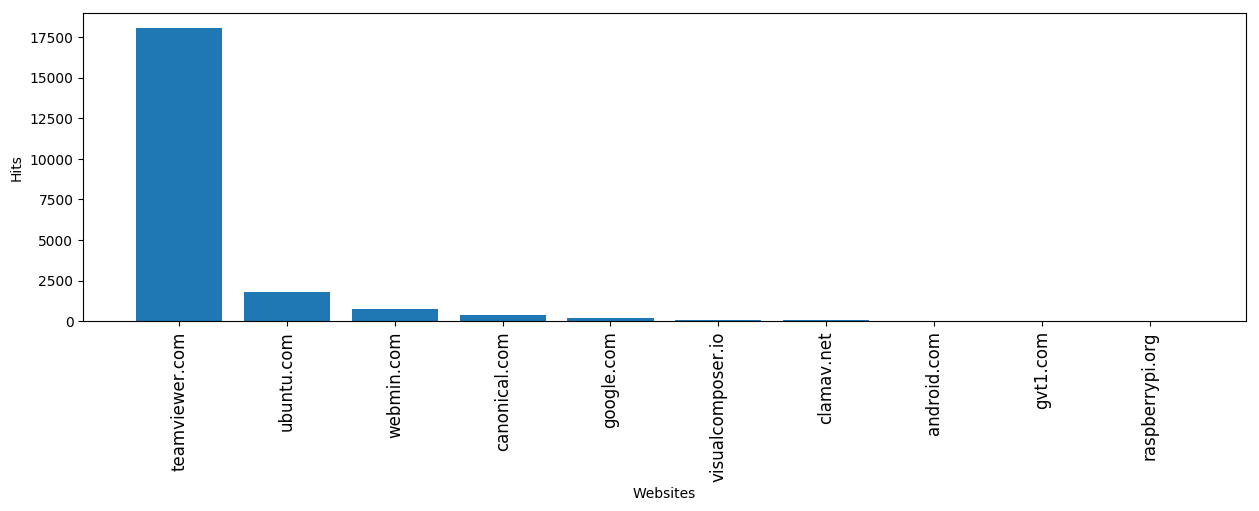

In [246]:
fig, ax = plt.subplots(figsize=(15, 4))

df_list = df_servers_ext[:10]

ax.bar(df_list.short_host, df_list.ip_src)

plt.xticks(fontsize=12, rotation='vertical')

ax.set_ylabel('Hits')
ax.set_xlabel('Websites')

plt.savefig('plots/http_hitlists_servers.pdf')
plt.show()
